In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn

In [145]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = RobustScaler()

unique_labels = train['type'].unique()
label_dict = {val: i for i, val in enumerate(unique_labels)}
i2lb = {v:k for k, v in label_dict.items()}
labels = train['type']
train = train.drop(columns=['fiberID', 'type'])
train_y = labels.replace(label_dict)

test_ids = test.index
test = test.drop(columns='fiberID')
train.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [146]:
feature_col = train.columns
train_k = train[train[feature_col] < -500]
train_k1 = train[train[feature_col] > 500]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train = train.drop(pre_index,axis=0).reset_index(drop=True)
train_y = train_y.drop(pre_index,axis=0).reset_index(drop=True)
train.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000,199944.000000
mean,20.986419,19.862615,19.284058,18.874251,18.612654,21.175680,20.090111,19.505196,19.087178,18.827976,20.709758,19.598765,19.014096,18.606045,18.399507,20.732539,19.531983,18.940843,18.521248,18.277572
std,2.609087,1.900398,2.211479,1.677545,1.759425,2.171585,1.846795,1.708268,1.626459,1.759209,3.488320,2.928588,2.491491,2.279988,3.075221,2.188525,1.961191,1.861893,1.798285,1.868713
min,-247.810033,-39.728588,-493.822787,-30.711890,-106.927107,-55.669722,-8.294703,-14.662435,10.646672,-139.831165,-422.715728,-461.827987,-130.554426,-307.627762,-410.624326,3.444448,8.686690,10.286917,11.337467,4.460086
25%,19.652920,18.701855,18.048938,17.748289,17.425949,19.941320,18.903617,18.259812,17.904291,17.606768,19.248182,18.114338,17.480244,17.050939,16.805072,19.266665,18.076409,17.423691,16.977958,16.705915
50%,20.871520,19.904298,19.454611,19.044250,18.611929,21.049353,20.069374,19.632040,19.189207,18.711245,20.366961,19.586802,19.183197,18.693853,18.174616,20.406952,19.547784,19.143413,18.641891,18.101232
75%,22.160333,21.150209,20.515945,20.073708,19.883750,22.337811,21.386101,20.774012,20.331551,20.133260,21.797223,21.004384,20.457476,20.019147,19.807460,21.992890,20.962117,20.408072,19.968873,19.819514
max,368.939515,102.124043,54.501228,164.878940,115.830481,274.083693,68.509385,32.574603,42.002047,173.583776,297.791928,270.432463,473.850080,219.701423,411.103073,49.487277,59.987842,35.102312,45.783550,61.597879


In [71]:
test.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


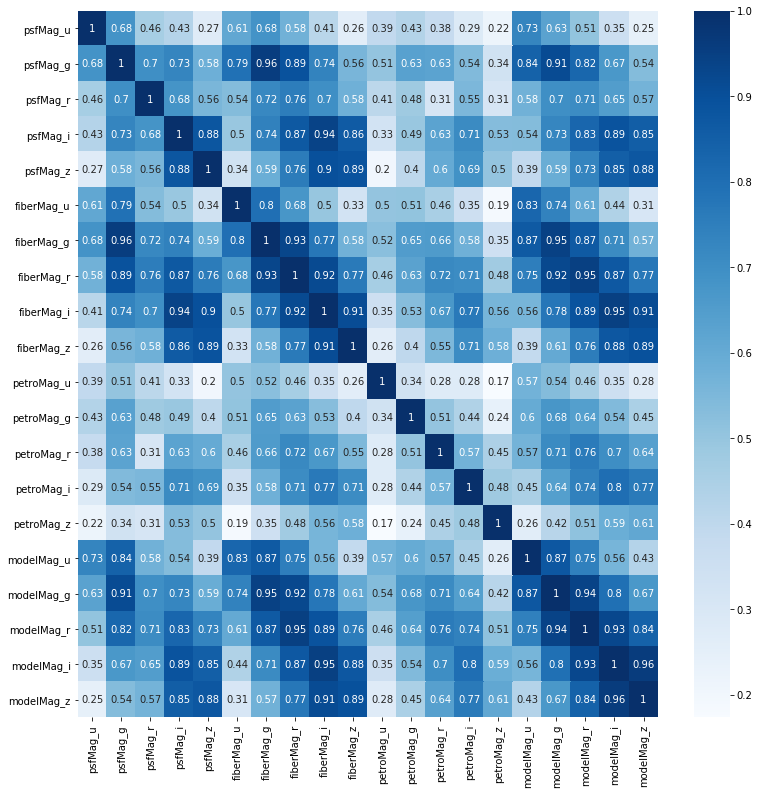

In [73]:
corrmat = train.corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="Blues")

In [0]:
train_x = pd.DataFrame(scaler.fit_transform(train),columns=feature_col, index = train.index )
test_x = pd.DataFrame(scaler.fit_transform(test),columns=feature_col, index = test.index)

In [75]:
train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999440e+05,199944.000000,1.999440e+05,199944.000000,1.999440e+05,1.999440e+05,199944.000000,1.999440e+05,1.999440e+05,199944.000000,199944.000000,199944.000000,1.999440e+05,1.999440e+05,199944.000000,1.999440e+05,199944.000000,199944.000000,1.999440e+05,1.999440e+05
mean,4.582366e-02,-0.017025,-6.913323e-02,-0.073105,2.948784e-04,5.271334e-02,0.008354,-5.045104e-02,-4.203457e-02,0.046203,0.134481,0.004139,-5.679821e-02,-2.958291e-02,0.074904,1.194277e-01,-0.005476,-0.067877,-4.033664e-02,5.663545e-02
std,1.040549e+00,0.776194,8.964214e-01,0.721394,7.158531e-01,9.061520e-01,0.743930,6.794480e-01,6.700801e-01,0.696305,1.368483,1.013336,8.368484e-01,7.681359e-01,1.024258,8.027677e-01,0.679622,0.623879,6.012490e-01,6.001779e-01
min,-1.071549e+02,-24.356314,-2.080567e+02,-21.396627,-5.107778e+01,-3.201309e+01,-11.425680,-1.364031e+01,-3.519415e+00,-62.751976,-173.823263,-166.576861,-5.029425e+01,-1.099389e+02,-142.819279,-6.221976e+00,-3.763754,-2.967616,-2.442204e+00,-4.381151e+00
25%,-4.859990e-01,-0.491123,-5.697887e-01,-0.557302,-4.825371e-01,-4.623562e-01,-0.469593,-5.457910e-01,-5.293688e-01,-0.437158,-0.438902,-0.509495,-5.719920e-01,-5.535037e-01,-0.456151,-4.182661e-01,-0.509884,-0.576241,-5.563293e-01,-4.481365e-01
50%,-7.084431e-16,0.000000,-7.200449e-16,0.000000,-7.227423e-16,7.412324e-16,0.000000,7.065292e-16,7.318362e-16,0.000000,0.000000,0.000000,5.966466e-16,5.984610e-16,0.000000,-6.515812e-16,0.000000,0.000000,-5.939175e-16,5.705157e-16
75%,5.140010e-01,0.508877,4.302113e-01,0.442698,5.174629e-01,5.376438e-01,0.530407,4.542090e-01,4.706312e-01,0.562842,0.561098,0.490505,4.280080e-01,4.464963e-01,0.543849,5.817339e-01,0.490116,0.423759,4.436707e-01,5.518635e-01
max,1.388156e+02,33.581638,1.420612e+01,62.713273,3.955509e+01,1.055854e+02,19.512713,5.147785e+00,9.398597e+00,61.299417,108.835019,86.796426,1.527147e+02,6.772017e+01,130.871962,1.066688e+01,14.013914,5.347474,9.074700e+00,1.396990e+01


In [76]:
import tensorflow as tf
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_custom_objects

class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [0]:
optimizer = tf.keras.optimizers.Adadelta(
    learning_rate=0.001,
)

In [0]:

class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.total_iterations = steps_per_epoch * epochs
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
epochs = 10
batch_size = 400
epoch_size = len(train_x)
lr_finder = LRFinder(min_lr=7e-6, 
                     max_lr=3e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)


In [0]:
norm_hid_rep = hidden_representation.predict(train_x)
# fraud_hid_rep = hidden_representation.predict(train_x[train_y!=0])

In [0]:
train_x = pd.DataFrame(norm_hid_rep, columns=train_x.columns, index = train_x.index)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=0)

for train_index, test_index in split.split(train_x, train_y):
    x_train, y_train = train_x.loc[train_index], train_y[train_index]
    x_val, y_val = train_x.loc[test_index] , train_y[test_index]

In [134]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=0, smote=SMOTE(sampling_strategy='auto', ratio={13:10000,11:9000,7:7500,14:7000,3:6500,0:6000,16:2300,2:5000,9:1500,17:4000,12:4000}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {8:32000,18:13000})).fit_sample(x_train, y_train)

ValueError: ignored

In [146]:
import lightgbm as lgb
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=60, max_depth=-1, learning_rate=0.005, 
                             n_estimators=3000, subsample_for_bin=400000, objective='multiclass', min_split_gain=0.1,
                             min_child_weight=5e-3, min_child_samples=12,n_jobs=-1, random_state=42)
lgb_model1 = lgb_clf1.fit(x_train,y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 1.34628
[200]	valid_0's multi_logloss: 0.98482
[300]	valid_0's multi_logloss: 0.787064
[400]	valid_0's multi_logloss: 0.66966
[500]	valid_0's multi_logloss: 0.597277
[600]	valid_0's multi_logloss: 0.551128
[700]	valid_0's multi_logloss: 0.520911
[800]	valid_0's multi_logloss: 0.500541
[900]	valid_0's multi_logloss: 0.4864
[1000]	valid_0's multi_logloss: 0.476372
[1100]	valid_0's multi_logloss: 0.469204
[1200]	valid_0's multi_logloss: 0.463891
[1300]	valid_0's multi_logloss: 0.459915
[1400]	valid_0's multi_logloss: 0.456929
[1500]	valid_0's multi_logloss: 0.454448
[1600]	valid_0's multi_logloss: 0.452451
[1700]	valid_0's multi_logloss: 0.450831


KeyboardInterrupt: ignored

In [0]:
rep_x = np.append(norm_hid_rep[:1000,:], fraud_hid_rep[:1000,:], axis = 0)
y_n = np.zeros(1000)
y_f = np.ones(1000)
rep_y = np.append(y_n, y_f)

No handles with labels found to put in legend.


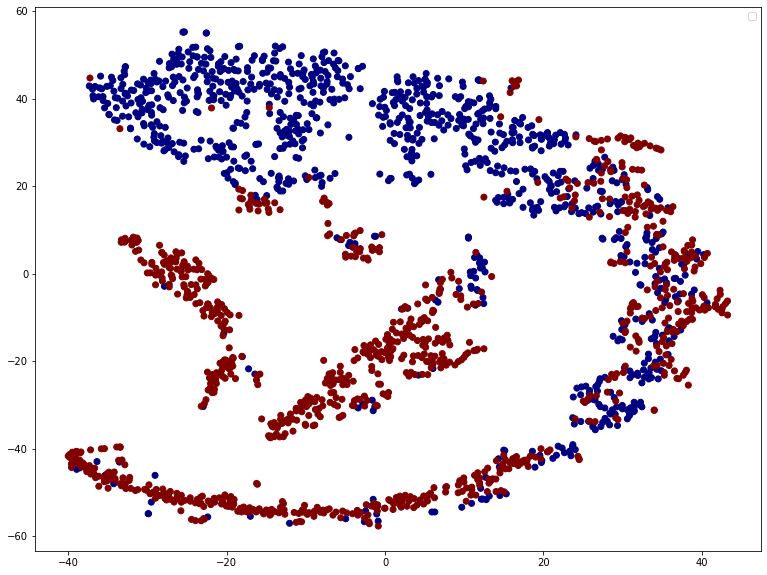

In [63]:

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(rep_x)
plt.figure(figsize=(13,10))
plot_digits()
plt.legend(loc="best")

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA()
x_train_pc = pca.fit_transform(x_train)
X = x_train_pc[156000:,:]
y = y_train[156000:]
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [100]:
x_train.shape

(159955, 20)

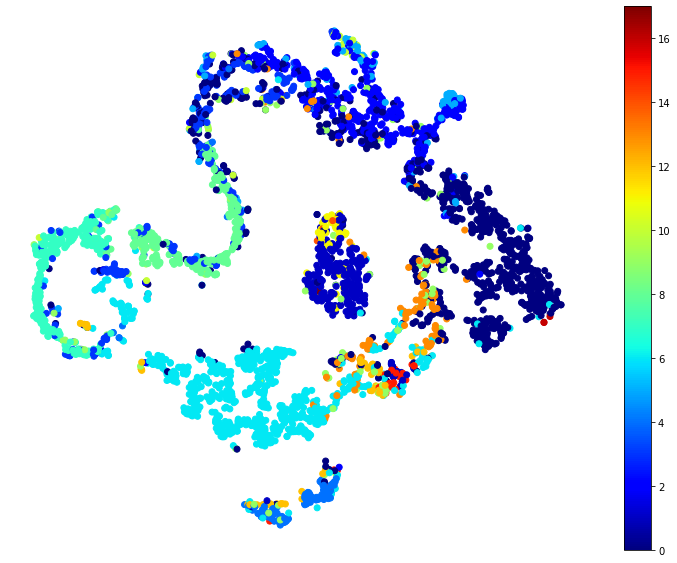

In [102]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet",)
plt.axis('off')
plt.colorbar()

In [0]:
def res_unit(inputs, channels):
    x = BatchNormalization()(inputs)
    x = Activation('mish')(x)
    x = Conv1D(channels, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    x = Conv1D(channels, kernel_size=3, padding='same', use_bias=False)(x)
    added = Add()([inputs, x])
    return added

def res_unit_stride(inputs, channels,pad='same'):
    x = BatchNormalization()(inputs)
    x = Activation('mish')(x)
    x = Conv1D(channels, kernel_size=3, strides=2, padding=pad, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    x = Conv1D(channels, kernel_size=3, padding=pad, use_bias=False)(x)
    conv = Conv1D(channels, kernel_size=1, strides=2, padding=pad, use_bias=False)(inputs)
    added = Add()([conv, x])
    return added

seq_in = Input(shape=(20,1))
x = Conv1D(16, kernel_size=3, activation='mish', padding='same')(seq_in)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit_stride(x, 32)
x =  res_unit(x, 32)
x =  res_unit(x, 32)
x =  res_unit(x, 32)
x =  res_unit_stride(x, 64)
x =  res_unit(x, 64)
x =  res_unit(x, 64)
x =  res_unit(x, 64)
x =  res_unit(x, 64)
x = BatchNormalization()(x)
x = Activation('mish')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, kernel_initializer='he_normal', activation='mish')(x)
seq = Dense(20, kernel_initializer='he_normal', activation='linear')(x)
# seq_out = Dense(19, kernel_initializer='he_normal', activation='softmax')(x)
seq_out = Reshape((20,1))(seq)
res_model = Model(inputs=seq_in , outputs=seq_out)

In [0]:
optimizer1 = tf.keras.optimizers.Nadam(learning_rate=0.001)
res_model.compile(optimizer=optimizer1,
              loss='mse',
              metrics=['mse'])
ckpt_path = ckpt_dir + '/encoder3_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='min')

In [0]:
set_data = pd.concat([train_x,test_x],axis=0)
x_train1 = np.expand_dims(set_data, axis=2)
epochs = 30
batch_size = 1024
epoch_size = len(set_data)
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)


In [169]:
train_x.shape

(199944, 20)

In [159]:
res_model.fit(x_train1,x_train1,batch_size=1024,callbacks=[ckpt,lr_finder],shuffle=True, validation_split=0.2,epochs=30)

Train on 167962 samples, validate on 41991 samples
Epoch 1/30
167962/167962 [==============================] - 28s 168us/sample - loss: 0.0980 - mean_squared_error: 0.0980 - val_loss: 0.2354 - val_mean_squared_error: 0.2354
Epoch 2/30
167962/167962 [==============================] - 13s 80us/sample - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 3/30
167962/167962 [==============================] - 13s 79us/sample - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 4/30
167962/167962 [==============================] - 13s 76us/sample - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 5/30
167962/167962 [==============================] - 12s 74us/sample - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0812 - val_mean_squared_error: 0.0812
Epoch 6/30
167962/167962 [==============================] - 13s 75us/sample - loss: 0.05

In [162]:
res_model.load_weights('/gdrive/My Drive/ckpt/encoder3_25_valloss0.04.hdf5')
res_model.fit(x_train1,x_train1,batch_size=1024,callbacks=[ckpt,lr_finder],shuffle=True, validation_split=0.25,epochs=30)

Train on 157464 samples, validate on 52489 samples
Epoch 1/30
157464/157464 [==============================] - 12s 75us/sample - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 2/30
157464/157464 [==============================] - 12s 74us/sample - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0507 - val_mean_squared_error: 0.0507
Epoch 3/30
157464/157464 [==============================] - 12s 77us/sample - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 4/30
157464/157464 [==============================] - 12s 74us/sample - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.1182 - val_mean_squared_error: 0.1182
Epoch 5/30
157464/157464 [==============================] - 12s 74us/sample - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0582 - val_mean_squared_error: 0.0582
Epoch 6/30
157464/157464 [==============================] - 12s 76us/sample - loss: 0.024

In [0]:
res_model.load_weights('/gdrive/My Drive/ckpt/encoder3_22_valloss0.02.hdf5')

In [167]:
from tensorflow.keras.models import Sequential
hidden_representation1 = Sequential()
for i in range(len(res_model.layers)):
  hidden_representation1.add(res_model.layers[i])

ValueError: ignored

In [0]:
new_set = res_model.predict(x_train1)
ntrain_x = new_set[:199944,:]
ntest_x = new_set[199944:,:]